In [23]:
import numpy as np
def readfileToNumpy(path):
    myList = []
    f = open(path, 'r',encoding='cp949')
    while True:
        line = f.readline()
        if not line: break
        if line == "\n": continue
        myList.append(line.split())
    f.close()
        
    return np.array(myList, dtype=object)

In [3]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

def showStockOfYear(companyStockOfYear, start, end):
    plt.figure(figsize=(40,20))
    plt.xlabel('DAY', labelpad=15)
    plt.ylabel('CLOSING PRICE', labelpad=20)
    ax=plt.axes()

    ax.xaxis.set_major_locator(ticker.MultipleLocator(10))
    ax.xaxis.set_minor_locator(ticker.MultipleLocator(1))

    ax.yaxis.set_major_locator(ticker.MultipleLocator(100))
    ax.yaxis.set_minor_locator(ticker.MultipleLocator(10))



    x = np.arange(0, len(companyStockOfYear[0]))
    for y in companyStockOfYear[start:end]:
        plt.plot(x, y)
    plt.show()

In [4]:
def getRateOfChange(companyStockOfYear):
    rateOfChangeOfYear = []
    for companyStock in companyStockOfYear:
        rateOfChange = []
        for i in range(1, len(companyStock)):
            roc = 100 * (float(companyStock[i])/float(companyStock[i-1]) - 1)
            rateOfChange.append(roc)
        rateOfChangeOfYear.append(rateOfChange)
    return np.array(rateOfChangeOfYear, dtype=object)

import math
def getDiffLog10(companyStockOfYear):
    diffLog10OfYear = []
    for companyStock in companyStockOfYear:
        diffLog10Change = []
        for i in range(1, len(companyStock)):
            diifLog10 = math.log10(float(companyStock[i])) - math.log10(float(companyStock[i-1]))
            diffLog10Change.append(diifLog10)
        diffLog10OfYear.append(diffLog10Change)
    return np.array(diffLog10OfYear, dtype=object)

In [17]:
#PATH_ETF_COMPANY_CODE = "./data/dataset_input/etf_list.txt" #(회사명 주식코드)로 이루어진 파일
#PATH_KRX_COMPANY_CODE = "./data/dataset_input/krx300_list.txt" #(회사명 주식코드)로 이루어진 파일
PATH_ETF_CLOSING_PRICE_OF_1YEAR = "./data/dataset_input/etf_cp_list.txt" #(584개의 회사에 대한 1년 개장일 248일 종가)로 이루어진 파일
PATH_KRX_CLOSING_PRICE_OF_1YEAR = "./data/dataset_input/krx300_cp_list.txt" #(584개의 회사에 대한 1년 개장일 248일 종가)로 이루어진 파일

In [30]:
etfStock = readfileToNumpy(PATH_ETF_CLOSING_PRICE_OF_1YEAR)
krxStock = readfileToNumpy(PATH_KRX_CLOSING_PRICE_OF_1YEAR)
stock = np.concatenate((etfStock, krxStock), axis=0)
stockRoc = getRateOfChange(stock)

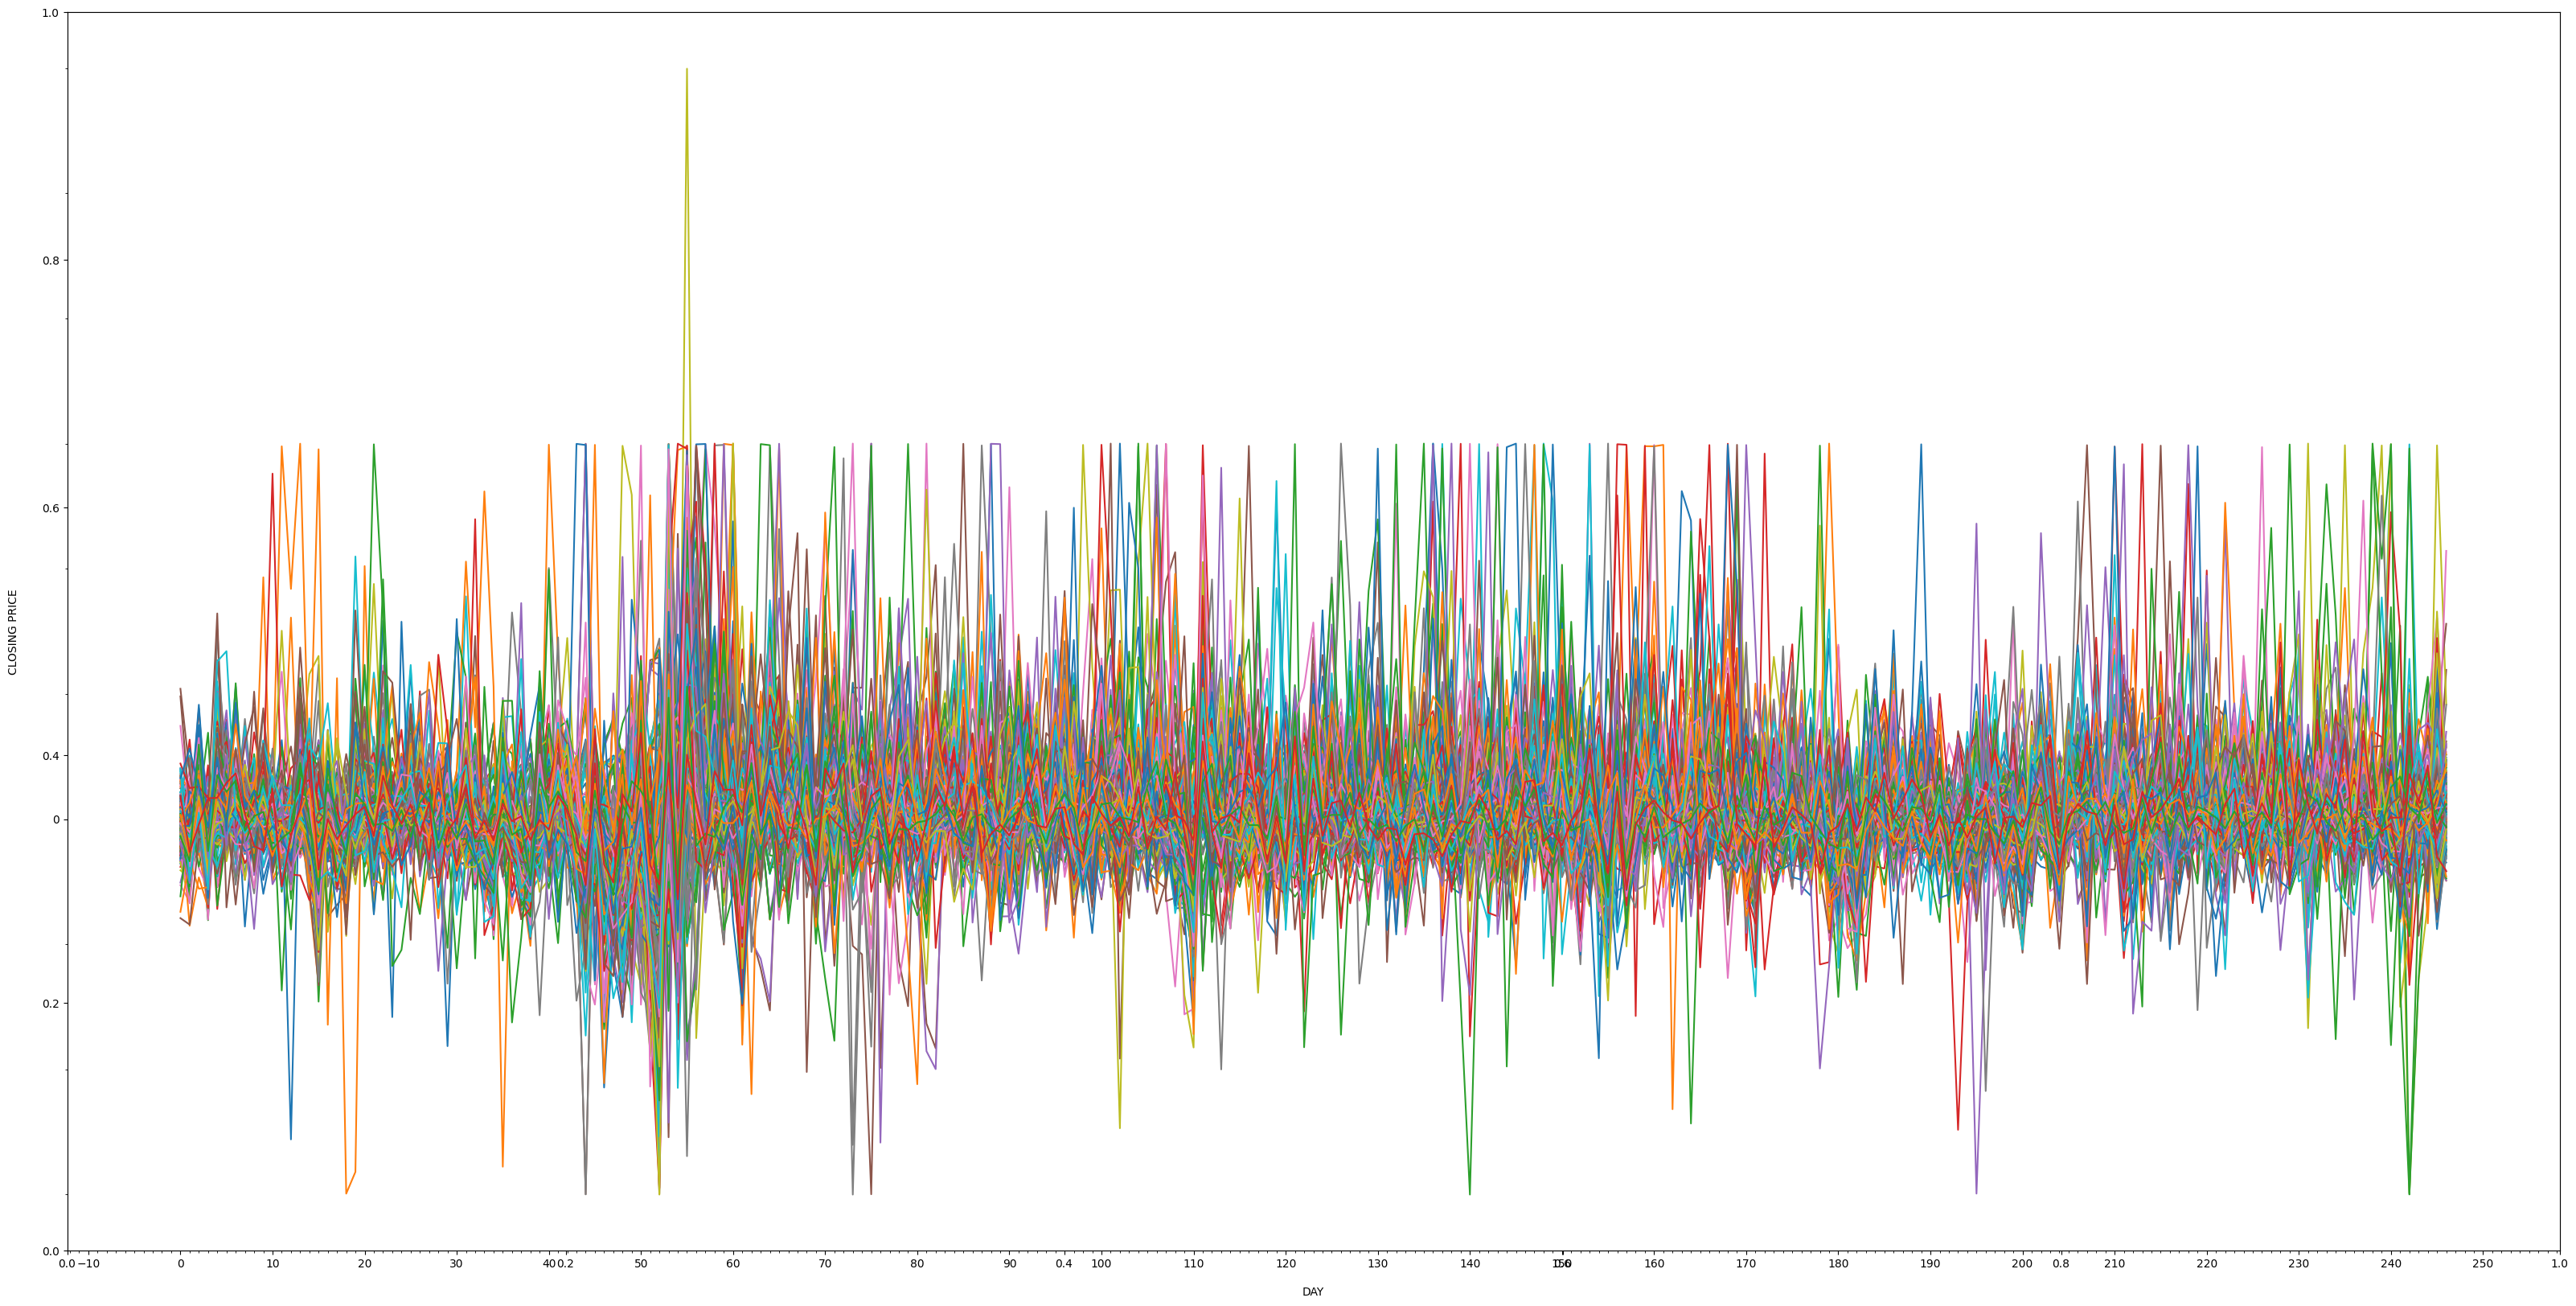

In [32]:
showStockOfYear(stockRoc, 0, 584)

In [33]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
fvs = pca.fit_transform(stockRoc.T)

In [34]:
# 초기 centeroid 세팅
f0min = min(fvs[:, 0])
f0max = max(fvs[:, 0])
f0half = (f0min + f0max) / 2
f1min = min(fvs[:, 1])
f1max = max(fvs[:, 1])
f1_a_third = f1min + (f0max - f1min) / 3
f1_two_thirds = f1max - (f0max - f1min) / 3

centeroid = np.zeros((6,2),float)
centeroid[0] = [(f0min+f0half)/2, (f1min+f1_a_third)/2]
centeroid[1] = [(f0min+f0half)/2, (f1_a_third+f1_two_thirds)/2]
centeroid[2] = [(f0min+f0half)/2, (f1_two_thirds+f1max)/2]
centeroid[3] = [(f0half+f0max)/2, (f1min+f1_a_third)/2]
centeroid[4] = [(f0half+f0max)/2, (f1_a_third+f1_two_thirds)/2]
centeroid[5] = [(f0half+f0max)/2, (f1_two_thirds+f1max)/2]

In [38]:
cluster_n = 6 #cluster 개수
iter = 10 # 클러스터링 알고리즘 반복 횟수
for it in range(iter):
    # 클러스터 별 분류된 기업의 인덱스 저장 dict
    cluster_dict = {"cluster" + str(i + 1): [] for i in range(cluster_n)}

    #update clusters
    for i in range(247):
        # L2 distance - 제곱근 수행 x
        min_distance_square = pow(centeroid[0][0]-fvs[i][0], 2) + pow(centeroid[0][1]-fvs[i][1], 2)
        cluster_name = "cluster1"
        for j in range(1, cluster_n):
            new_distance = pow(centeroid[j][0]-fvs[i][0], 2) + pow(centeroid[j][1]-fvs[i][1], 2)
            if min_distance_square > new_distance:
                min_distance_square = new_distance
                cluster_name = "cluster" + str(j+1)
        cluster_dict[cluster_name].append(i)
    # 반복 횟수 별 클러스터링 결과 출력
    #plot_result_of_clustering(fvs, cluster_dict, cluster_n, centeroid, it+1)

    # update centeroid vectors
    for i in range(cluster_n):
        f0_centeroid = 0
        f1_centeroid = 0
        cnt = 0
        for cnum in cluster_dict["cluster"+str(i+1)]: # cnum : unique number of company
            f0_centeroid += fvs[cnum][0]
            f1_centeroid += fvs[cnum][1]
            cnt += 1
        centeroid[i] = [f0_centeroid/cnt, f1_centeroid/cnt]
